## Efficient Protein Ground State Energy Computation via Fragmentation and Reassembly

### Motivation

The objective from a biological standpoint is to address the challenge of efficiently simulating proteins by fragmenting them into amino acids. Proteins are the fundamental basis for all interactions in the body, and their characterization is essential for understanding biological processes and advancing drug discovery. Notably, all proteins in the human body are composed of the same 20 amino acids. Therefore, we aim to develop a method for fragmenting proteins into their corresponding amino acids and then reassembling them post-simulation, incorporating chemical corrections to ensure the accurate reconstitution of the original molecule.

This work is therefore based on a set of hypotheses and assumptions that guide the design and development of the proposed methodology. First, it is assumed that large molecules, such as proteins, can be fragmented into amino acids without significantly compromising the global properties of the molecule. This assumption is supported by the fact that amino acids are chemically well-defined and biologically relevant units that can be studied independently and reassembled. Second, it is further assumed that any residual interactions between fragments can be addressed through specific energetic adjustments. Third and last, it is acknowledged that current quantum computers are noisy and limited in terms of available qubits, so the proposed methodology is designed to ensure the efficient implementation of the strategy.

Here we present with the detailed pipeline on how to compute the GSE for a small peptide through fragmentation, reassembly, and chemical corrections. The last section also presents with an already prepared function to automatically return the energy of your own protein by introducing a few charactestics.

### Pipeline

First of all, we developed a database containing the 20 essential amino acids with some of their main characteristics and their ground state energy computed classically. This enabled us to automated the process of fragmentation and reassembly of each amino acid. The following code gives an idea on how the database was constructed (you have it as csv format in the data folder):

In [7]:
import pandas as pd
data = pd.read_csv("C:/Users/lclai/Desktop/protein_fragmentation/data/aminoacids.csv") # here change the path corresponding to your directory
data.head(5)

,id,aa,mf,energy,mw,polararea,complexity,xlogp,heavycnt,hbonddonor,hbondacc,rotbonds,exactmass,monoisotopicmass,covalentunitcnt,isotopeatomcnt,totalatomstereocnt,definedatomstereocnt,electrones,S
0,6274.0,hystidine,C6H9N3O2,-538.52442,155.15,92.0,151.0,-3.2,11.0,3.0,4.0,3.0,155.069,155.069,1.0,0.0,1.0,1.0,82.0,0.0
1,6306.0,leucine,C6H13NO2,-433.42225,131.17,63.3,103.0,-1.7,9.0,2.0,3.0,3.0,131.095,131.095,1.0,0.0,2.0,2.0,72.0,0.0
2,6106.0,isoleucine,C6H13NO2,-432.82708,131.17,63.3,101.0,-1.5,9.0,2.0,3.0,3.0,131.095,131.095,1.0,0.0,1.0,1.0,72.0,0.0
3,5962.0,lysine,C6H14N2O2,-487.74060,146.19,89.3,106.0,-3.0,10.0,3.0,4.0,5.0,146.106,146.106,1.0,0.0,1.0,1.0,80.0,0.0
4,6137.0,methionine,C5H11NO2S,-788.02138,149.21,88.6,97.0,-1.9,9.0,2.0,4.0,4.0,149.051,149.051,1.0,0.0,1.0,1.0,80.0,1.0


And for every protein we can think of we can obtain the energies from the amino acids present in its sequence. For example, if we were interest in obtaining the energy for a the following protein:

SER - GLY - GLUT

We would have to filter and obtain the energi corresponding to the amino acids serine (SER), glycine (GLY) and glutamic acid (GLU).

In [8]:
energy_glycine = data.loc[data['aa'] == 'glycine', 'energy'].values[0]
energy_valine = data.loc[data['aa'] == 'valine', 'energy'].values[0]
energy_alanine = data.loc[data['aa'] == 'alanine', 'energy'].values[0]

So, to summarize, the first steo would be to fragment our peptide into its corresponding amino acids. This is a trivial step since all proteins are by definition described as their amino acid sequence.

We can crealy see this partition in the protein that we have just mentioned:

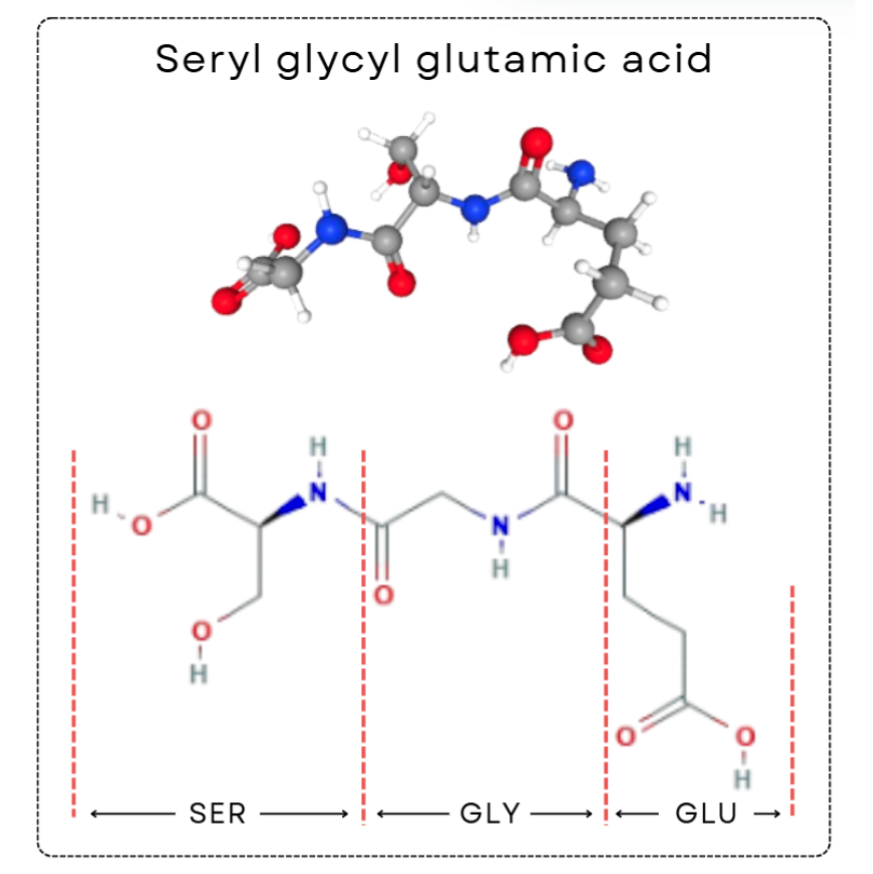

Once the protein has been fragmented, the next steps is to compute the energy corresponding to each of the fragments. However, since we already have the energy of every amino acid in the same dataabse we can jump directly to the next step that would be reassembly.

For that, our strategy consists on implementing the following equation: 

$$
E_{m} = \sum_{i=1}^{n} E_{f_i} \pm \sum_{j=1}^{k} E_{am_j}
$$

Where $n$ is the protein's total number of fragments generated, $E_{f_i}$ is the GSE corresponding to each fragment, $k$ is the total number of molecules lost or added within the process, $E_{am_j}$ corresponds to the GSE of each additional molecule, and $E_m$ corresponds to the final GSE of the molecule obtained through reassembly. Here, $i$ is the index that enumerates the $n$ fragments of the protein generated, with $i = 1, 2, \dots, n$. Similarly, $j$ represents the index of the $k$ additional or removed molecules during the process, with $j = 1, 2, \dots, k$.

To the identify additional molecules one has to analize the original molecule before the fragmentation. For example, tipically if the bond is formed betweent he cabroxi and the amino terminal groups of the amino acids, a molecula of water is going to be released. Another case could be that of aspartame, where we have ASP-PHE-CH3, which means we would have to add the energy corresponding to the methyl group (CH3). 

Now that we know how this is done, let's do it for the SER-GLY-GLU peptide. As mentioned, we first fragtioned this chain into three different amino acids. If we take a look at the previous chain we can see that the three amino acids are bonded through typical peptidic bonds, which mean we would have to account for the release of a total of 2 water molecules. Furthermore, all of them present their physiological conformation, meaning we will not have to account for the energy of any additional group.

In conclusion, this means that the final energy for this specific protein chain will we the sum of each amino acid energy minus two times the energy of a water molecule. This process can be easily understood by taking a look into the following image:

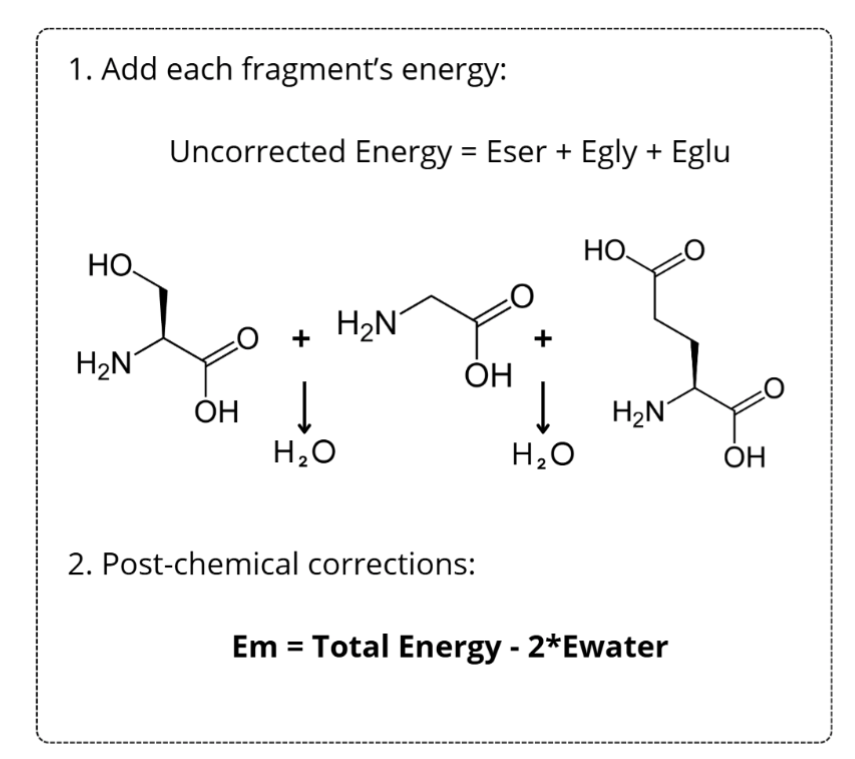

For the additional molecules the energy can be calculated classically (take a look in the code we provide in "ground_truth") or from quantum chemistry databases such as CCCBDB (https://cccbdb.nist.gov/energy1x.asp).

All these operations are implemented in the following code:

In [11]:
energy_water = -74.9659 #GSE of the water molecule obtained form the cccbdb database

total_energy_gly_val_ala = energy_glycine + energy_alanine + energy_valine #summing all the energies

reassembly_gly_val_ala = total_energy_gly_val_ala - 2*energy_water #adding chemical corrections corresponding to bond formation

print(f"Energy of gly-val-ala through reassembly is {reassembly_gly_val_ala} Hartrees") #final energy of our peptide

Energy of gly-val-ala through reassembly is -841.71855 Hartrees


Finally, in case we have the ground truth energy of our protein of interest, we can compute the relative error between our strategy and such energy by implementing the following function:

In [12]:
import numpy as np

gt_gly_val_ala = -841.68835 #define here manually your ground truth

def relative_error(gt,computed):
    '''function to compute the relative percentage error between the reassembly and the ground
    truth energy, the arguments correspond to these energies, respectively'''
    dif = np.abs(gt-computed)
    error = dif/np.abs(gt)
    percentage_error = error * 100
    return percentage_error
    
relative_error_gly_val_ala = relative_error(gt_gly_val_ala,reassembly_gly_val_ala)
print(f"The RE% of the reassebly for the gly-val-ala peptide is {relative_error_gly_val_ala} %")

The RE% of the reassebly for the gly-val-ala peptide is 0.003588026375800045 %


### Automating the process for you

Lastly, if you want to directly obtain the energy of a certain peptide you can just run the following cell and input the information that is going to be asked. Use the previous tutorial as a guid to obtained or otherwise you can leave it blank if you do not know it, but you will be probably facing higher error rates.

In [ ]:
from energy_computation import compute_protein_energy

total_energy = compute_protein_energy()

ValueError: invalid literal for int() with base 10: ''

### Hope this has been useful with your calculations and do not forget to cite us if you use this code!